In [ ]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import pearsonr, pointbiserialr
from statsmodels.formula.api import ols

from utilities import (
    DATE_GROUPINGS,
    DYESTUFFS,
    EXOTIC,
    FOOD_PREPARATION,
    HOUSEHOLD,
    LINENS,
    LUXURY,
    PA_FULL,
    PA_OBJECTS,
    VAR_GROUPS,
    WEAPONS_AND_ARMOUR,
)

warnings.filterwarnings('ignore')


In [2]:
# Load data
df = pd.read_csv('data/dataset.csv')
key = pd.read_csv('data/key.csv')

# Melt to long format
df_long = df.melt(
    id_vars=['id', 'date_group', 'object_phrases'],
    value_vars=PA_OBJECTS,
    var_name='object_type',
    value_name='present',
)
df_long_full = df.melt(
    id_vars=['id', 'date_group', 'object_phrases'],
    value_vars=PA_FULL,
    var_name='object_type',
    value_name='present',
)

# Group by date_group and object_type
dategroup = df_long.groupby(['date_group', 'object_type'])['present'].sum().unstack(fill_value=0)
dategroup_full = df_long_full.groupby(['date_group', 'object_type'])['present'].sum().unstack(fill_value=0)


# Compare intuitive perception of household wealth against presumed metrics

This analysis looks at how an intuitive assessment of a household's wealth (`wealth_points`) compares to previously assumed objective metrics, namely the number of object phrases in the inventory (`object_phrases`) and the quantity of linens stored in the household (`total_linens`).


Correlation Results with P-Values:


,Column 1,Column 2,Correlation,P-Value
0,wealth_points,object_phrases,0.829664,5.646820e-23
1,wealth_points,total_linens,0.799579,2.701631e-20
2,object_phrases,wealth_points,0.829664,5.646820e-23
3,object_phrases,total_linens,0.760244,2.081071e-17
4,total_linens,wealth_points,0.799579,2.701631e-20
5,total_linens,object_phrases,0.760244,2.081071e-17


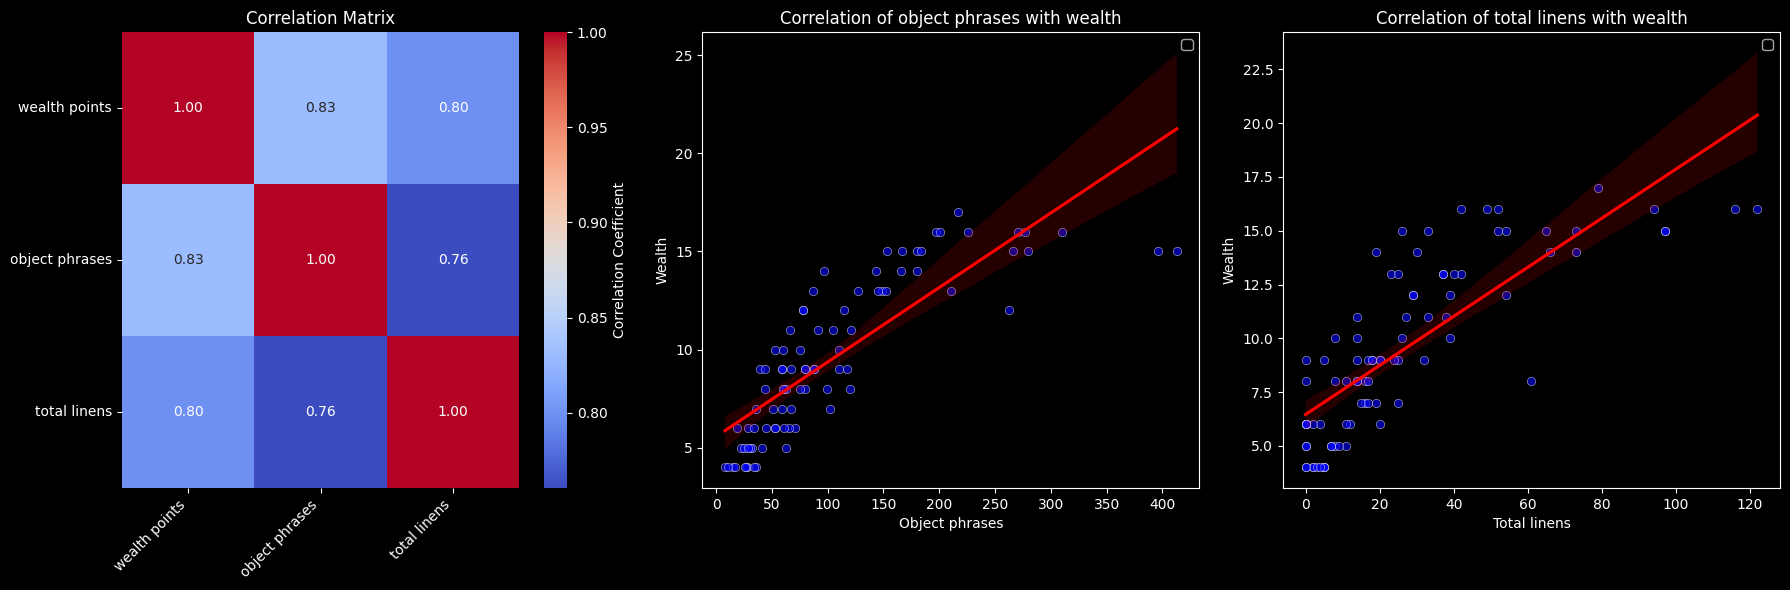

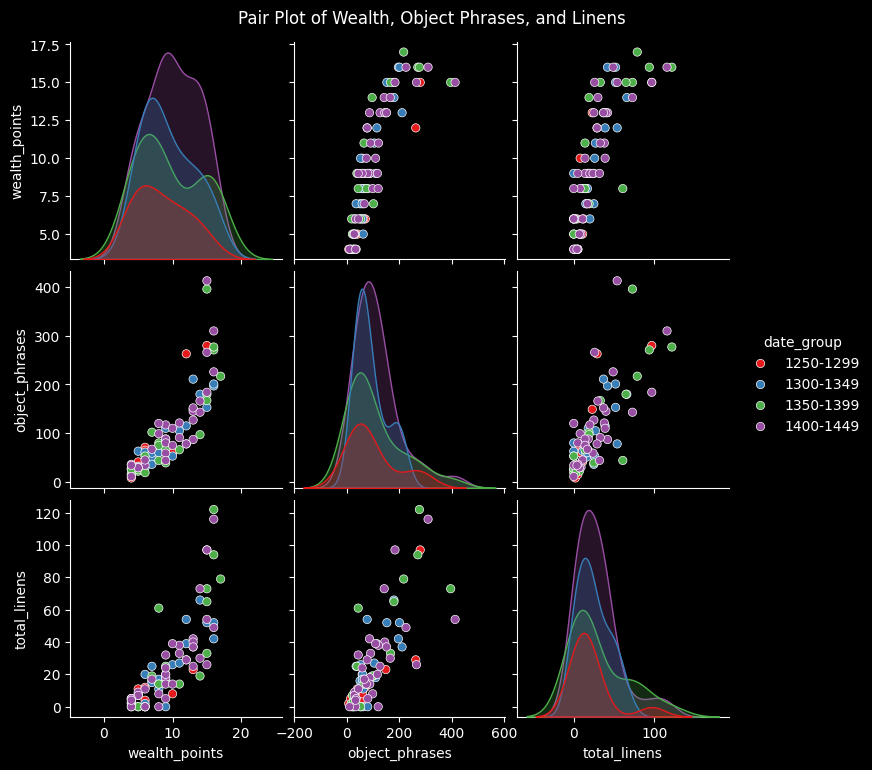

In [3]:
# Analyze correlation with p-values between wealth_points, object_phrases, and total_linens
columns_to_correlate = ['wealth_points', 'object_phrases', 'total_linens']
correlation_results = []

# Calculate correlation coefficients and p-values
for col1 in columns_to_correlate:
    for col2 in columns_to_correlate:
        if col1 != col2:
            corr, p_value = pearsonr(df[col1], df[col2])
            correlation_results.append({'Column 1': col1, 'Column 2': col2, 'Correlation': corr, 'P-Value': p_value})

# Convert results to DataFrame
correlation_results_df = pd.DataFrame(correlation_results)

# Display correlation results
print('Correlation Results with P-Values:')
display(correlation_results_df)

# Visualize results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Correlation matrix
correlation_matrix = df[columns_to_correlate].corr()
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    cbar_kws={'label': 'Correlation Coefficient'},
    ax=axes[0],
)
axes[0].set_title('Correlation Matrix')
axes[0].set_xticklabels(
    [label.get_text().replace('_', ' ') for label in axes[0].get_xticklabels()],
    rotation=45,
    ha='right',
)
axes[0].set_yticklabels([label.get_text().replace('_', ' ') for label in axes[0].get_yticklabels()], rotation=0)

# Visualize individual correlations
for i, col in enumerate(['object_phrases', 'total_linens'], start=1):
    sns.scatterplot(data=df, x=col, y='wealth_points', ax=axes[i], color='blue', alpha=0.6)
    sns.regplot(
        data=df,
        x=col,
        y='wealth_points',
        ax=axes[i],
        scatter=False,
        color='red',
        line_kws={'label': 'Trendline'},
    )
    axes[i].set_title(f'Correlation of {col.replace("_", " ")} with wealth')
    axes[i].set_xlabel(col.replace('_', ' ').capitalize())
    axes[i].set_ylabel('Wealth')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Pair Plot: Visualize pairwise relationships between variables
sns.pairplot(
    df[['wealth_points', 'object_phrases', 'total_linens', 'date_group']],
    diag_kind='kde',
    corner=False,
    hue='date_group',
    palette='Set1',
)
plt.suptitle('Pair Plot of Wealth, Object Phrases, and Linens', y=1.02)
plt.show()


## Interpretation

All correlations are strong and statistically significant, with p-values far below 0.05. Wealth is strongly correlated with both the number of object phrases and the quantity of linens in a household.

**Wealth (`wealth_points`) and Object phrases (`object_phrases`):**
- Correlation: 0.830 (strong positive correlation)
- P-Value: 5.65e-23 (highly statistically significant)

**Wealth (`wealth_points`) and Quantity of linens (`total_linens`):**
- Correlation: 0.800 (strong positive correlation)
- P-Value: 2.70e-20 (highly statistically significant)

**Object phrases (`object_phrases`) and Quantity of linens (`total_linens`):**
- Correlation: 0.760 (strong positive correlation)
- P-Value: 2.08e-17 (highly statistically significant)


# How do indicators of wealth and the number of object phrases per inventory change over time?


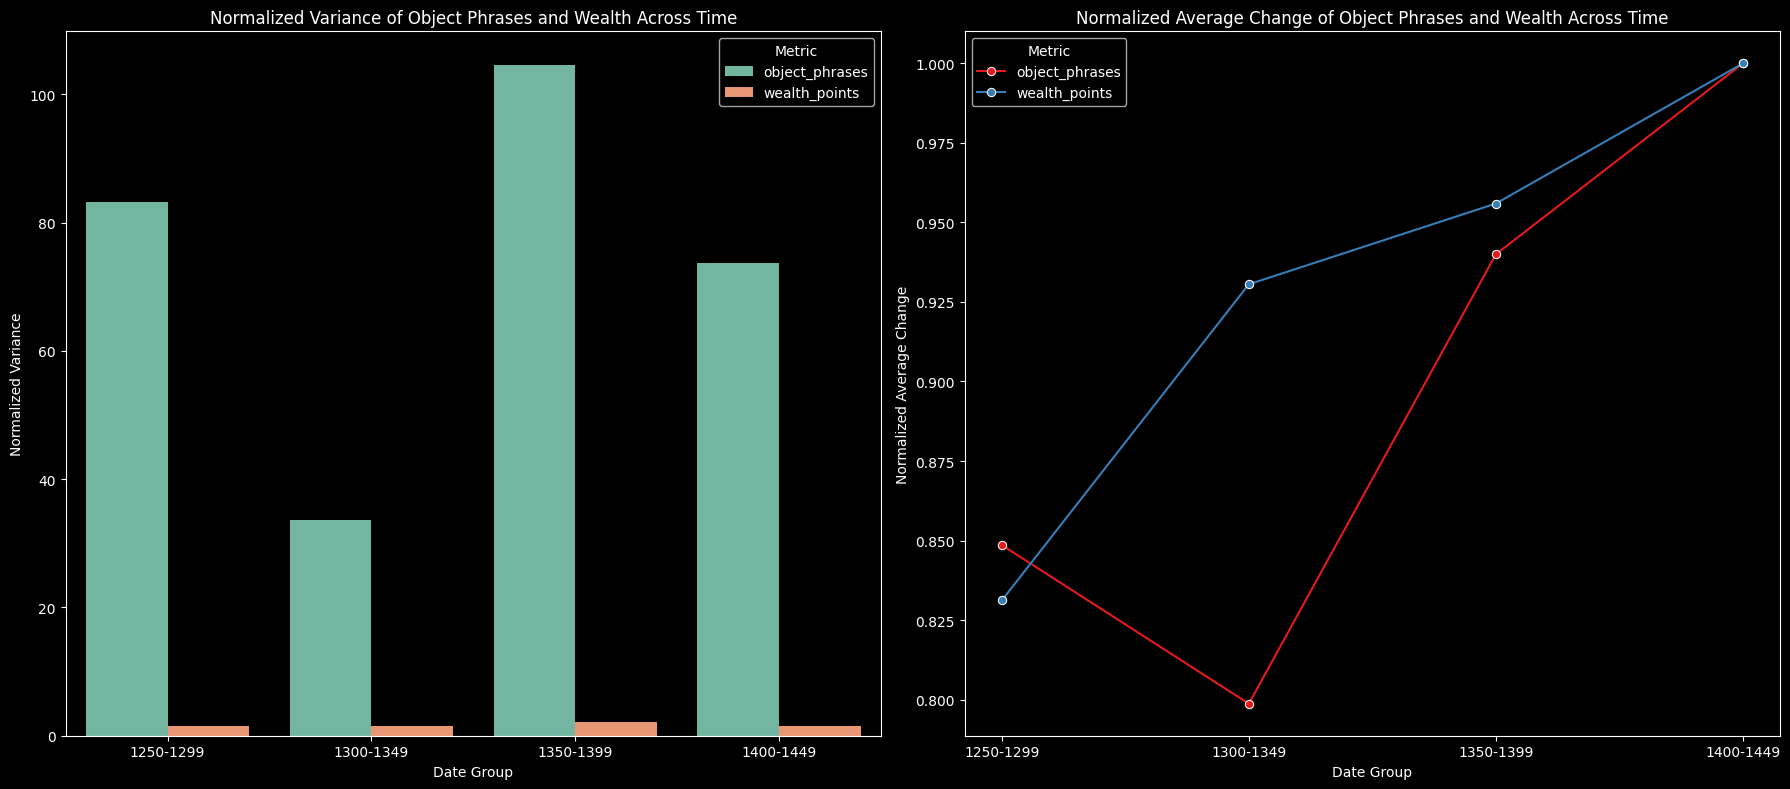

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Compare variance across time between 'object_phrases' and 'wealth_points' across 'DATE_GROUPINGS'
df['date_group'] = df['year'].apply(
    lambda x: next((group for group, years in DATE_GROUPINGS.items() if x in years), 'Unknown')
    if 'year' in df.columns
    else 'Unknown',
)

# Group by 'date_group' and calculate variance
variance_df = df.groupby('date_group')[['object_phrases', 'wealth_points']].var().reset_index()

# Normalize variance by dividing by the mean of each column
mean_values = df[['object_phrases', 'wealth_points']].mean()
variance_df[['object_phrases', 'wealth_points']] = variance_df[['object_phrases', 'wealth_points']].div(
    mean_values,
    axis=1,
)

# Plot normalized variance comparison
sns.barplot(
    data=variance_df.melt(id_vars='date_group', var_name='Metric', value_name='Normalized Variance'),
    x='date_group',
    y='Normalized Variance',
    hue='Metric',
    palette='Set2',
    ax=axes[0],
)
axes[0].set_title('Normalized Variance of Object Phrases and Wealth Across Time')
axes[0].set_xlabel('Date Group')
axes[0].set_ylabel('Normalized Variance')
plt.legend(title='Metric')
plt.xticks()
plt.tight_layout()


# Compare average change across time between 'object_phrases' and 'wealth_points'
# Calculate average change for each metric within each date group
average_change_df = df.groupby('date_group')[['object_phrases', 'wealth_points']].mean().reset_index()

# Normalize the average change by dividing by the maximum value of each column
max_values = average_change_df[['object_phrases', 'wealth_points']].max()
average_change_df[['object_phrases', 'wealth_points']] = average_change_df[['object_phrases', 'wealth_points']].div(
    max_values,
    axis=1,
)

# Plot normalized average change comparison
sns.lineplot(
    data=average_change_df.melt(id_vars='date_group', var_name='Metric', value_name='Normalized Average Change'),
    x='date_group',
    y='Normalized Average Change',
    hue='Metric',
    marker='o',
    palette='Set1',
    ax=axes[1],
)
axes[1].set_title('Normalized Average Change of Object Phrases and Wealth Across Time')
axes[1].set_xlabel('Date Group')
axes[1].set_ylabel('Normalized Average Change')
plt.legend(title='Metric')
plt.xticks()
plt.tight_layout()
plt.show()


## Interpretation

Variance in the number of object phrases in the 1250-1299 period is relatively high, suggesting diverse household inventories. The variance in wealth is moderate, indicating some variability in wealth distribution. At the same time, both the number of object phrases and wealth show moderate average changes, indicating some variability in household inventories and wealth. 

In the following period, 1300-1349, variance in the number of object phrases drops significantly suggesting perhaps more uniformity in household inventories. The variance in wealth remains similar, suggesting consistent wealth distribution. The average change in the number of object phrases decreases slightly, suggesting more stability in household inventories. However, the average change in wealth increases, indicating growing variability in wealth. 

The period from 1350-1399 stands out with the highest variance in both the number of object phrases and wealth, a sharp increase from the previous period that likely reflects significant diversity in household inventories and greater economic disparities. Both the number of object phrases and wealth show significant increases in average change, reflecting heightened variability in household inventories and wealth during the same period. 

Lastly, between 1400 and 1449, the variance in the number of object phrases decreases from the previous period but remains relatively high, indicating continued diversity in household inventories. Variance in wealth stabilizes at a lower level, suggesting a return to more consistent wealth distribution. Both metrics reach their peak average change, indicating the highest levels of variability in household inventories and wealth during this period. These metrics may indicate economic recovery or consolidation after a period of upheaval.


**1250-1299:**
- `object_phrases` variance: 83.16
- `object_phrases` avg. change: 0.8486 (84.86% of the maximum average change)
- `wealth_points` variance: 1.49
- `wealth_points` avg. change: 0.8312 (83.12% of the maximum average change)

**1300-1349:**
- `object_phrases` variance: 33.63
- `object_phrases` avg. change: 0.7987 (79.87% of the maximum average change)
- `wealth_points` variance: 1.46
- `wealth_points` avg. change: 0.9305 (93.05% of the maximum average change)

**1350-1399:**
- `object_phrases` variance: 104.62
- `object_phrases` avg. change: 0.9400 (94.00% of the maximum average change)
- `wealth_points` variance: 2.21
- `wealth_points` avg. change: 0.9559 (95.59% of the maximum average change)

**1400-1449:**
- `object_phrases` variance: 73.73
- `object_phrases` avg. change: 1.0000 (100% of the maximum average change)
- `wealth_points` variance: 1.46
- `wealth_points` avg. change: 1.0000 (100% of the maximum average change)


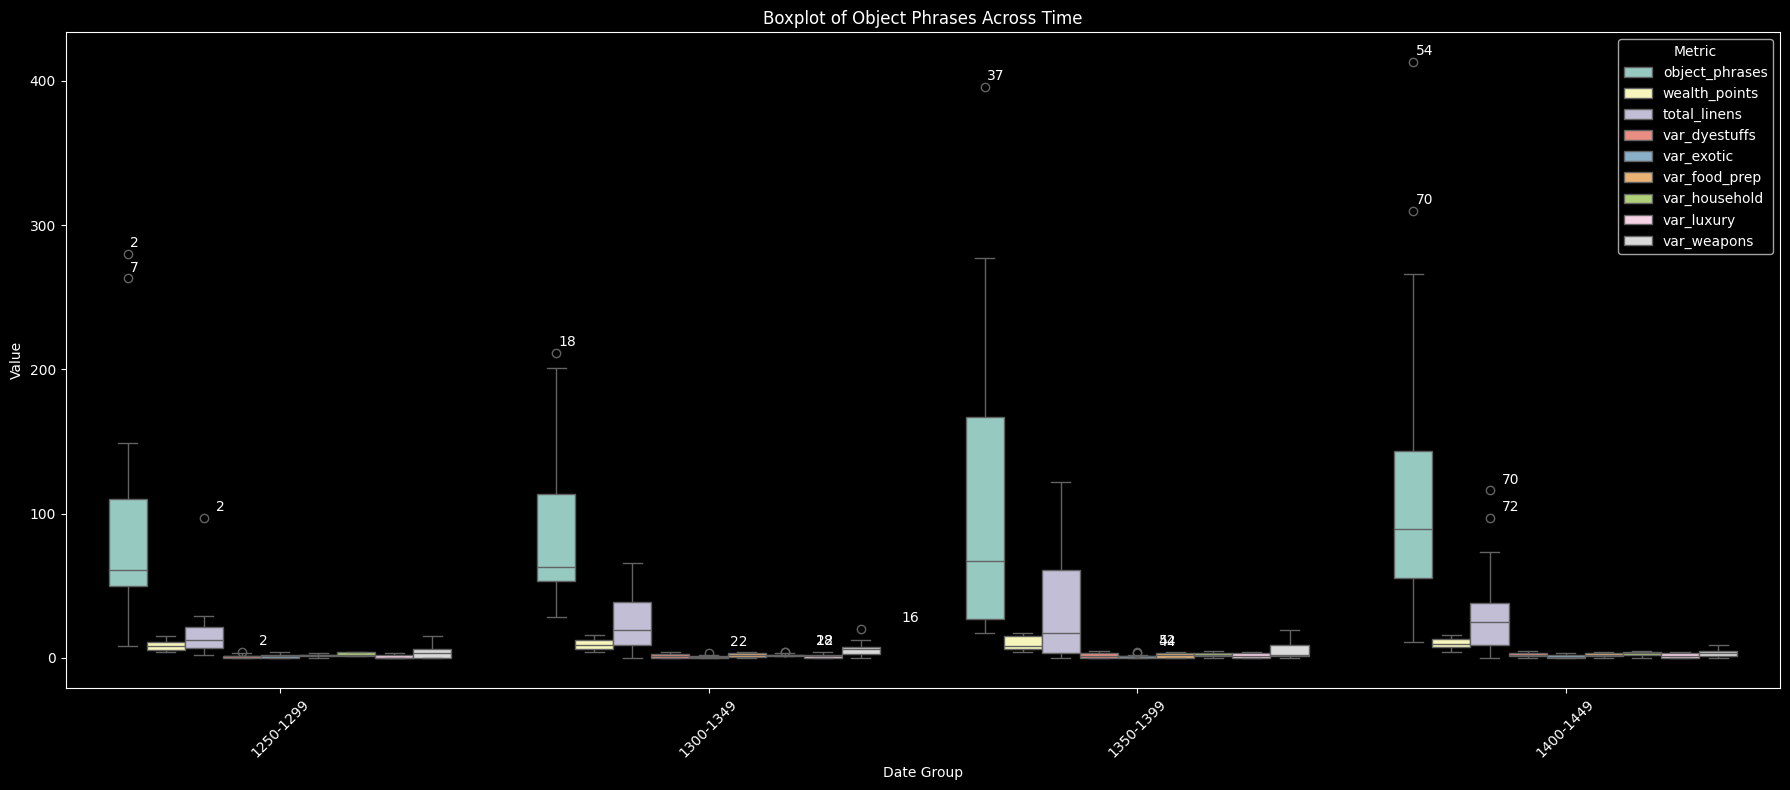

Outliers:


,record,type,year,date_group
2,Colratus Cavallerii (AMM 1 II 21),Inventory-Guardianship,1295,1250-1299
7,Ricardus Jullani (AMM FF 501),Inventory-Guardianship,1297,1250-1299
16,Fulco Amati (ADBR 3B 32),Inventory-Guardianship,1336,1300-1349
18,Guillelmus Egidii (AMM 1 II 58),Inventory-Postmortem,1347,1300-1349
22,Franciscus de Serralonga (ADBR 355E 1),Inventory-Postmortem,1348,1300-1349
37,Berengarius de Bulbono (AMM 2 II 291),Inventory-Postmortem,1360,1350-1399
44,Andreas de Garda (ADBR 392E 1),Inventory-Guardianship,1394,1350-1399
52,Antonius Fabri (ADBR 3B 128),Inventory-Postmortem,1397,1350-1399
54,Philipponus Colini (ADBR 5G 771),Inventory-Postmortem,1400,1400-1449
70,Rixendis Cambale (ADBR 355E 309),Inventory-Guardianship,1410,1400-1449


Numeric results:


count        mean         std   min    25%   50%  \
date_group Metric                                                             
1250-1299  object_phrases   11.0   97.454545   93.454121   8.0  50.00  61.0   
           total_linens     11.0   20.636364   26.691844   2.0   6.50  12.0   
           var_dyestuffs    11.0    1.090909    1.375103   0.0   0.00   1.0   
           var_exotic       11.0    1.272727    1.420627   0.0   0.00   1.0   
           var_food_prep    11.0    1.545455    1.035725   0.0   1.00   2.0   
           var_household    11.0    2.545455    1.293340   1.0   1.50   2.0   
           var_luxury       11.0    1.000000    1.264911   0.0   0.00   0.0   
           var_weapons      11.0    4.272727    4.859854   0.0   0.00   3.0   
           wealth_points    11.0    8.363636    3.775519   4.0   5.50   8.0   
1300-1349  object_phrases   22.0   91.727273   59.430778  28.0  53.00  63.0   
           total_linens     22.0   24.181818   19.769231   0.0   8.75  19.0   
           var_dyestuffs    22.0    1.500000    1.371478   0.0   0.00   1.0   
           var_exotic       22.0    0.681818    0.838727   0.0   0.00   0.5   
           var_food_prep    22.0    1.681818    1.323285   0.0   0.25   2.0   
           var_household    22.0    1.909091    0.971454   1.0   1.00   2.0   
           var_luxury       22.0    1.090909    1.230915   0.0   0.00   1.0   
           var_weapons      22.0    5.727273    4.871509   0.0   2.25   6.0   
           wealth_points    22.0    9.363636    3.735868   4.0   6.25   8.5   
1350-1399  object_phrases   21.0  107.952381  104.821027  17.0  27.00  67.0   
           total_linens     21.0   31.476190   35.920216   0.0   3.00  17.0   
           var_dyestuffs    21.0    1.809524    1.631534   0.0   0.00   1.0   
           var_exotic       21.0    0.952381    1.071270   0.0   0.00   1.0   
           var_food_prep    21.0    1.761905    1.374946   0.0   0.00   2.0   
           var_household    21.0    2.285714    1.553797   0.0   1.00   2.0   
           var_luxury       21.0    1.523810    1.435933   0.0   0.00   1.0   
           var_weapons      21.0    5.285714    6.141196   0.0   1.00   2.0   
           wealth_points    21.0    9.619048    4.598654   4.0   6.00   8.0   
1400-1449  object_phrases   32.0  114.843750   87.997107  11.0  55.50  89.5   
           total_linens     32.0   28.625000   26.944088   0.0   8.75  24.5   
           var_dyestuffs    32.0    2.031250    1.635974   0.0   1.00   2.0   
           var_exotic       32.0    0.843750    0.954087   0.0   0.00   0.5   
           var_food_prep    32.0    2.093750    1.146084   0.0   1.00   2.0   
           var_household    32.0    2.718750    1.275941   0.0   2.00   3.0   
           var_luxury       32.0    1.500000    1.391217   0.0   0.00   1.5   
           var_weapons      32.0    3.156250    2.541391   0.0   1.00   3.0   
           wealth_points    32.0   10.062500    3.741119   4.0   7.75   9.5   

                              75%    max  
date_group Metric                         
1250-1299  object_phrases  110.00  280.0  
           total_linens     21.50   97.0  
           var_dyestuffs     1.50    4.0  
           var_exotic        2.00    4.0  
           var_food_prep     2.00    3.0  
           var_household     4.00    4.0  
           var_luxury        2.00    3.0  
           var_weapons       6.00   15.0  
           wealth_points    11.00   15.0  
1300-1349  object_phrases  113.75  211.0  
           total_linens     38.50   66.0  
           var_dyestuffs     2.75    4.0  
           var_exotic        1.00    3.0  
           var_food_prep     3.00    4.0  
           var_household     2.00    4.0  
           var_luxury        2.00    4.0  
           var_weapons       7.75   20.0  
           wealth_points    12.00   16.0  
1350-1399  object_phrases  167.00  396.0  
           total_linens     61.00  122.0  
           var_dyestuffs     3.00    5.0  
           var_exotic        1.00  

In [5]:
plt.figure(figsize=(18, 8))

target_columns = ['object_phrases', 'wealth_points', 'total_linens', *VAR_GROUPS]
plot_data = df.melt(
    id_vars=['id', 'date_group'],
    value_vars=target_columns,
    var_name='Metric',
    value_name='Value',
)

sns.boxplot(
    data=plot_data,
    x='date_group',
    y='Value',
    palette='Set3',
    hue='Metric',
)
plt.title('Boxplot of Object Phrases Across Time')
plt.xlabel('Date Group')
plt.ylabel('Value')
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()

# Add outlier labels
outliers = []
num_metrics = len(target_columns)  # Total number of metrics
for i, metric in enumerate(target_columns, start=1):
    for group_index, group in enumerate(DATE_GROUPINGS):
        df_group = df[df['date_group'] == group]
        for _, row in df_group.iterrows():
            if row[metric] > df_group[metric].quantile(0.75) + 1.5 * (
                df_group[metric].quantile(0.75) - df_group[metric].quantile(0.25)
            ):
                outliers.append(row['id'])
                # Calculate x position for annotation
                x_offset = (i - num_metrics / 2) * 0.1  # Adjust the multiplier (e.g., 0.1) for spacing
                x_pos = group_index + x_offset
                plt.annotate(
                    str(row['id']),
                    xy=(x_pos, row[metric]),
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=10,
                )


plt.show()

# print data for outliers
print('Outliers:')
display(df[df['id'].isin(outliers)][['record', 'type', 'year', 'date_group']])

print('Numeric results:')
results = plot_data.groupby(['date_group', 'Metric'])['Value'].describe()
display(results)


## Interpretation

In the period from 1250 to 1299, the number of object phrases per inventory and the quantity of linens per household show high variability, as indicated by the large standard deviations. This suggests that household inventories were highly diverse during this time, with some households possessing significantly more items than others. Wealth, on the other hand, shows relatively low variability, indicating a more consistent distribution of wealth across households. This period may reflect a stable economic environment where wealth disparities were minimal, but household inventories varied widely due to differences in lifestyle or access to goods. 

Between 1300 and 1349, most metrics show decreased variability. The standard deviation for object phrases and linens decreases, suggesting that household inventories became more uniform. Wealth variability remains similar to the previous period, indicating continued consistency in wealth distribution. This period may reflect a time of economic consolidation or standardization in household practices, where differences in inventories were less pronounced. 

In the period from 1350 to 1399, the number of object phrases, the quantity of linens, and wealth overall reach peak variability. The high standard deviations for these metrics suggest significant material diversity and economic disparities. This period likely reflects a time of upheaval or transition, where some households accumulated wealth and goods while others did not. The sharp increase in variability could be attributed to external factors such as economic shocks, pandemics, wars, or changes in trade practices. 

Finally, between 1400 and 1449, wealth and the quantity of linens stabilize, as indicated by lower standard deviations compared to the previous period. This suggests a return to more consistent wealth distribution and textile inventories. However, the high variability in the number of object phrases persists, likely reflecting continued diversity in household inventories or changes in inventory practices. This period may indicate economic recovery or consolidation after the upheaval of the previous century, with households diversifying their possessions even as wealth distribution became more stable.



# How does the presence of different classes of objects correlate with wealth?

Point-Biserial Correlation Results for Dyestuffs:


,column,correlation,p_value
0,black_dyestuff,0.550187,4.078591e-08
1,green_dyestuff,0.734416,8.496936e-16
2,purple_dyestuff,0.491041,1.584759e-06
3,ruby_red_dyestuff,0.604172,7.324206e-10
4,yellow_dyestuff,0.482772,2.507556e-06


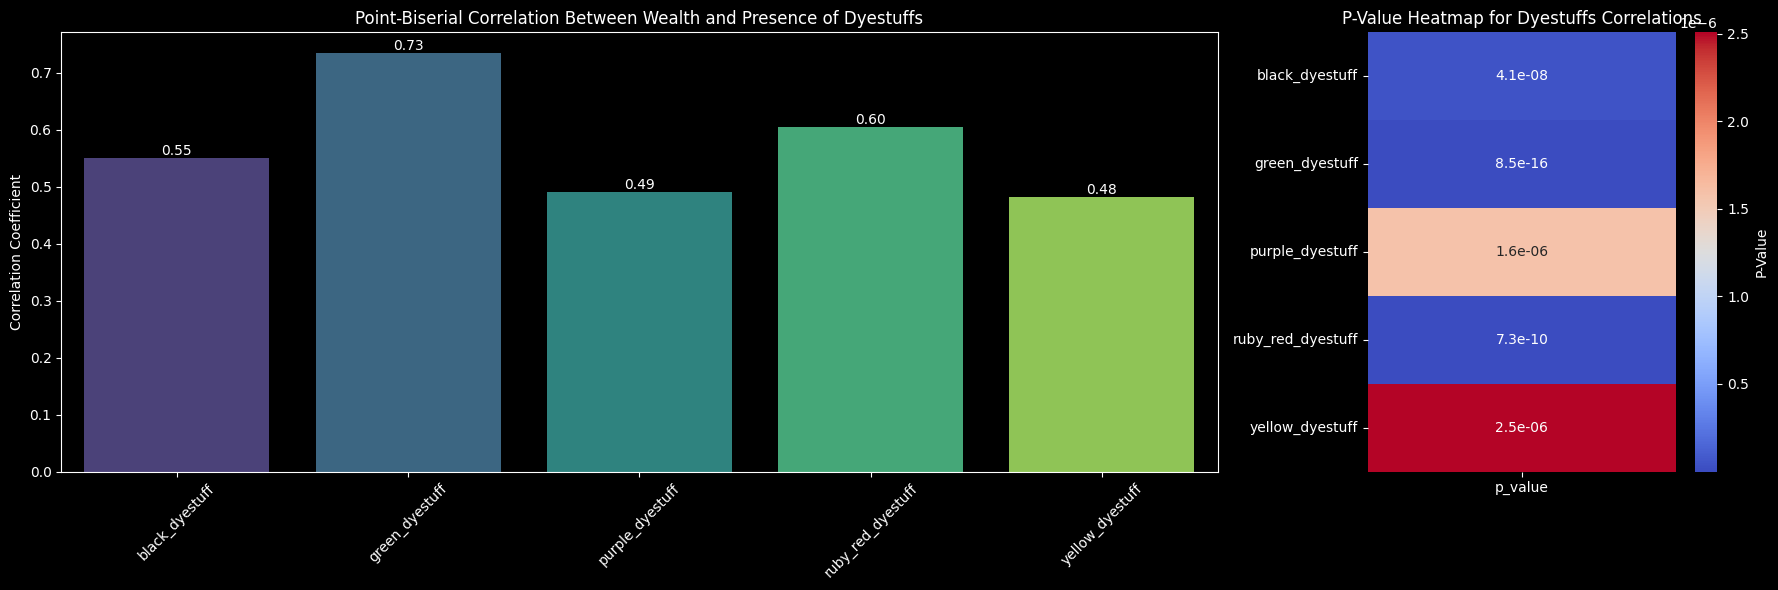

Point-Biserial Correlation Results for Exotic Objects:


,column,correlation,p_value
0,alexandria,0.319013,2.755696e-03
1,amber,0.477093,3.412959e-06
2,bejaia,0.199586,6.541933e-02
3,damascus,0.115990,2.875560e-01
4,pearls,0.650368,1.226844e-11
5,turkey,0.240057,2.599521e-02


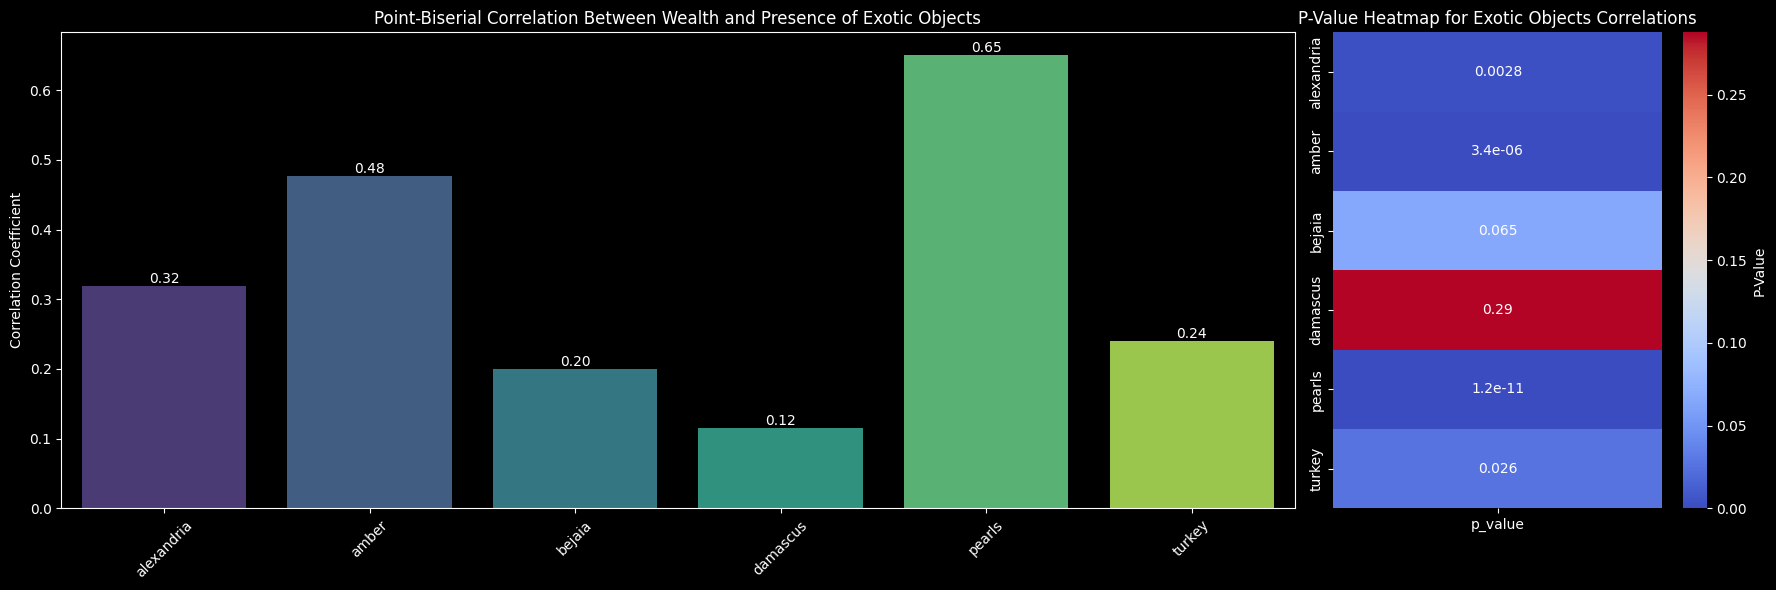

Point-Biserial Correlation Results for Food Preparation:


,column,correlation,p_value
0,alembics,0.365356,5.422065e-04
1,dough_troughs,0.363036,5.917102e-04
2,mortars,0.484658,2.260743e-06
3,spits,0.634013,5.642538e-11


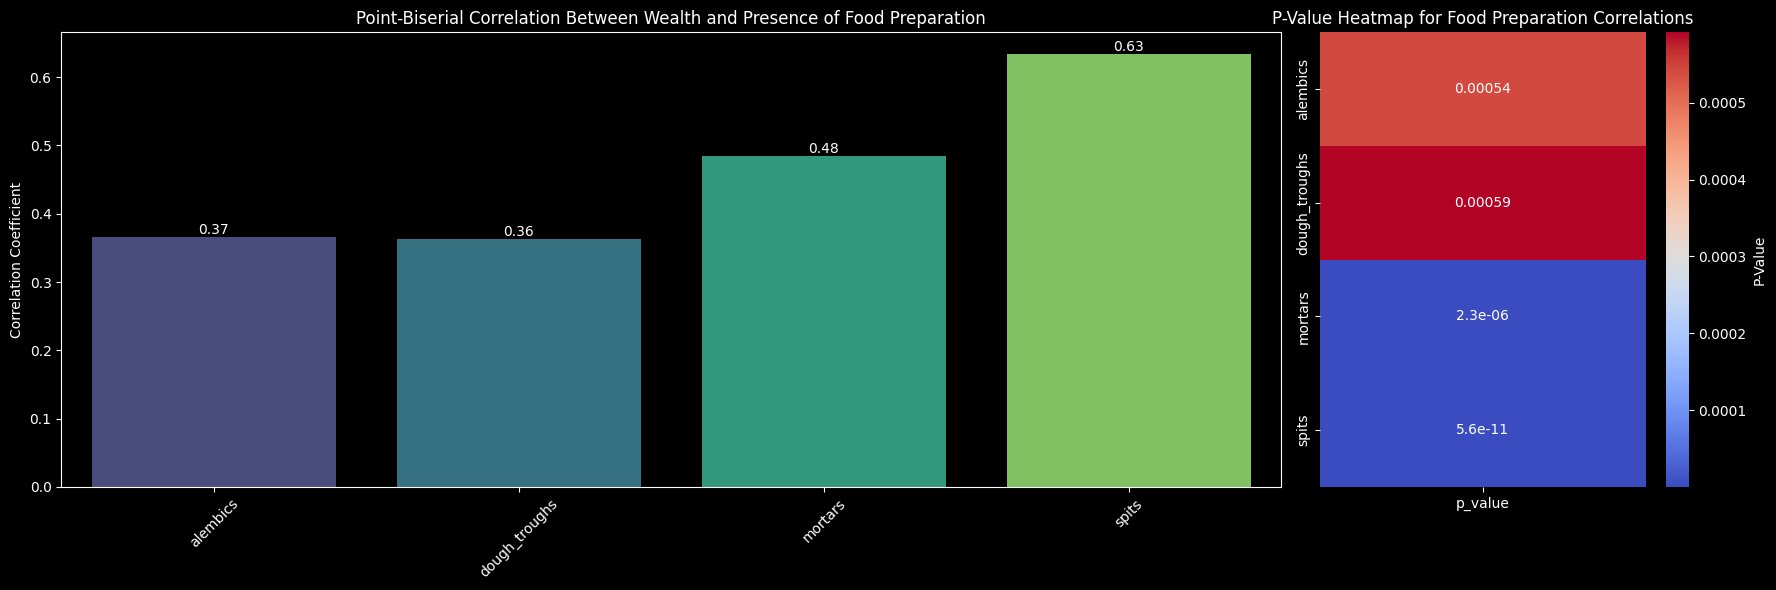

Point-Biserial Correlation Results for Household Objects:


,column,correlation,p_value
0,candelabra,0.479882,0.000003
1,lamps,0.166268,0.126013
2,cushions,0.233500,0.030487
3,pillows,0.410727,0.000086


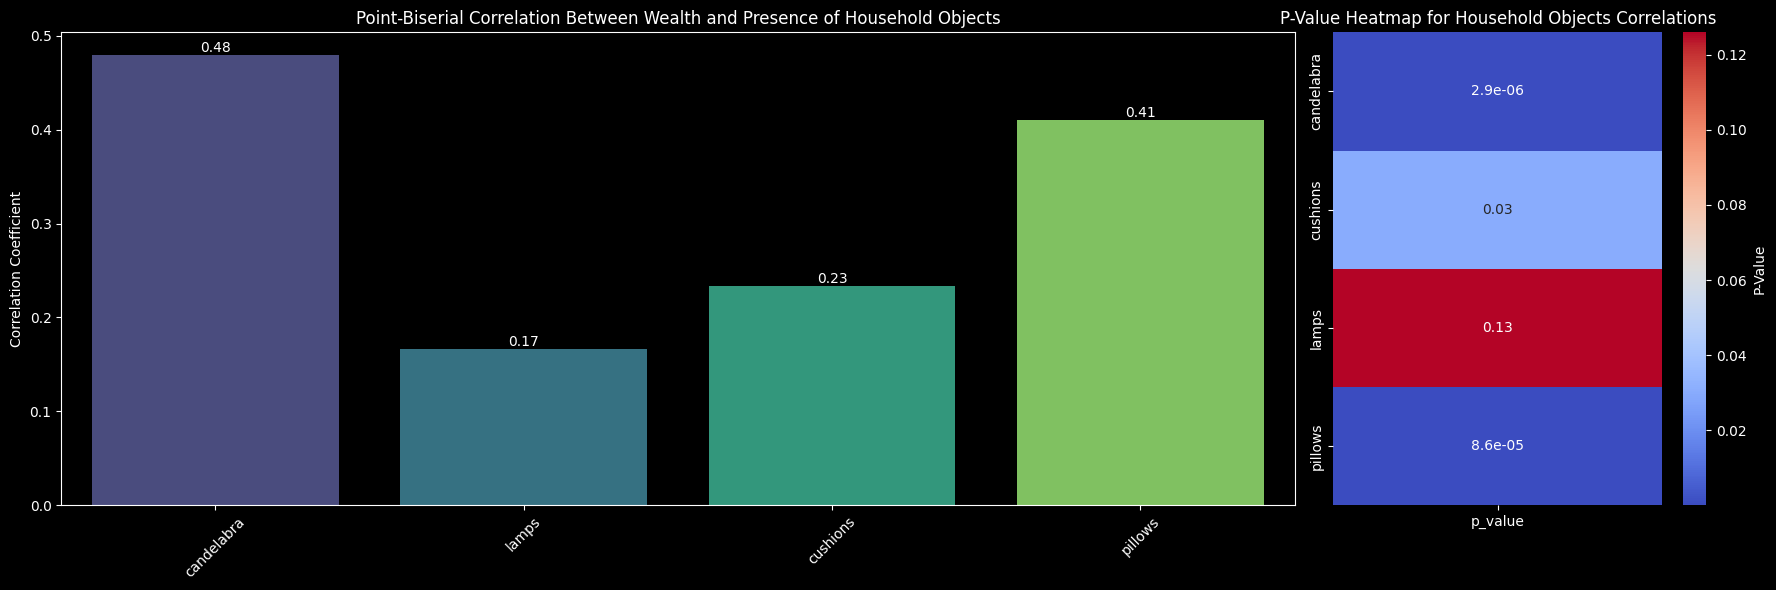

Point-Biserial Correlation Results for Linens:


,column,correlation,p_value
0,bedsheets,0.357542,0.000726
1,tablecloths,0.481121,0.000003
2,tunics,0.162051,0.136046


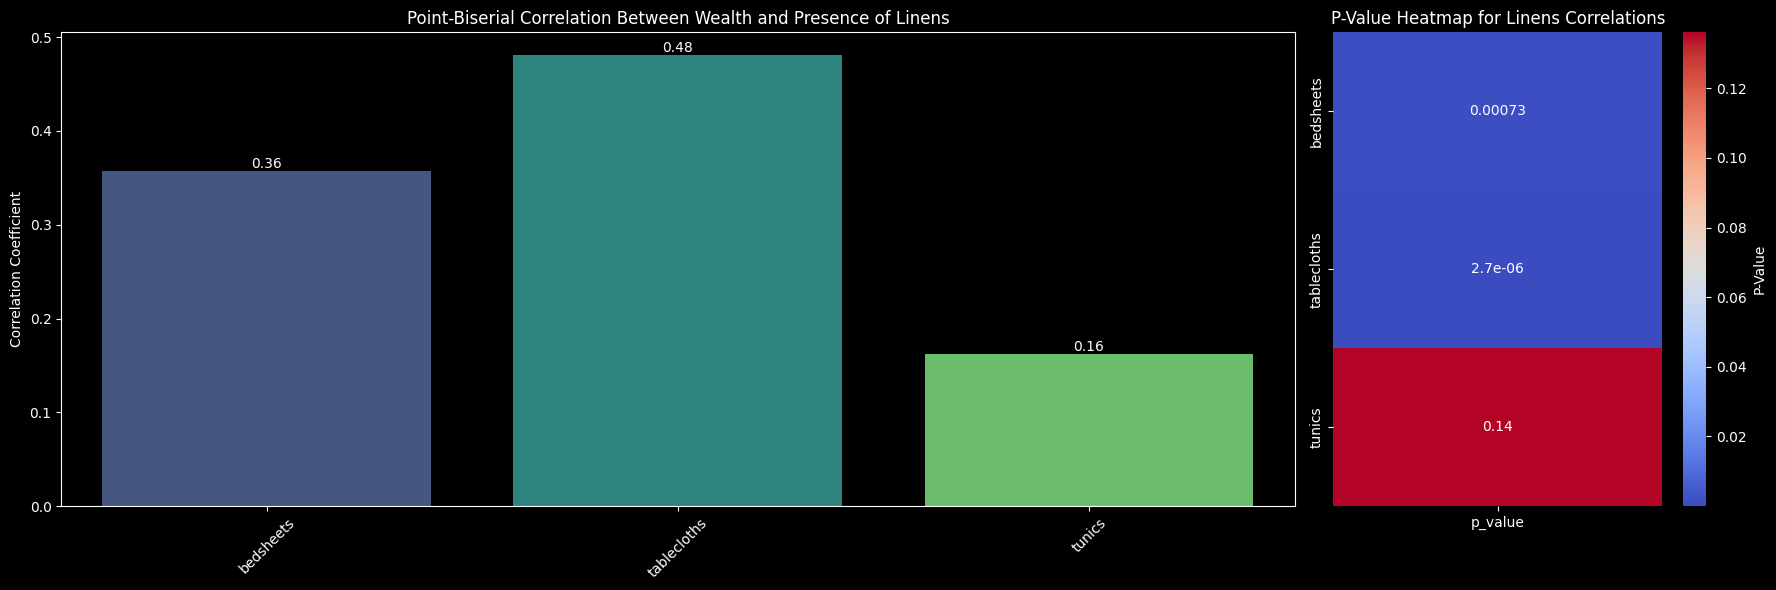

Point-Biserial Correlation Results for Luxury Objects:


,column,correlation,p_value
0,belts,0.547061,5.038937e-08
1,gold_jewellery,0.546583,5.203190e-08
2,sendal,0.617455,2.419246e-10
3,silk,0.595676,1.449031e-09


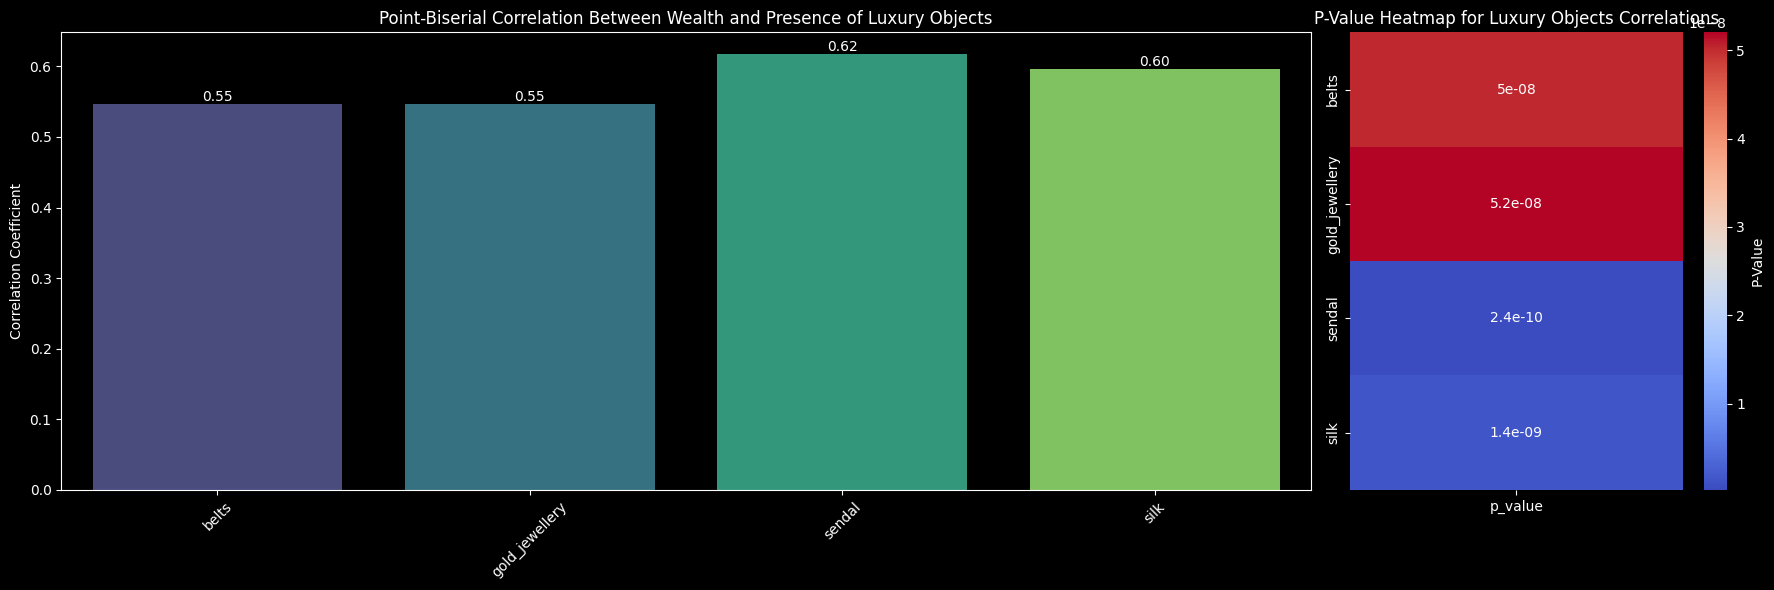

Point-Biserial Correlation Results for Weapons and Armor:


,column,correlation,p_value
0,armour,0.532324,1.326757e-07
1,melee_weapons,0.464692,6.565935e-06
2,polearms,0.358677,6.960175e-04
3,projectile_weapons,0.302052,4.706566e-03
4,shields,0.441713,2.067639e-05


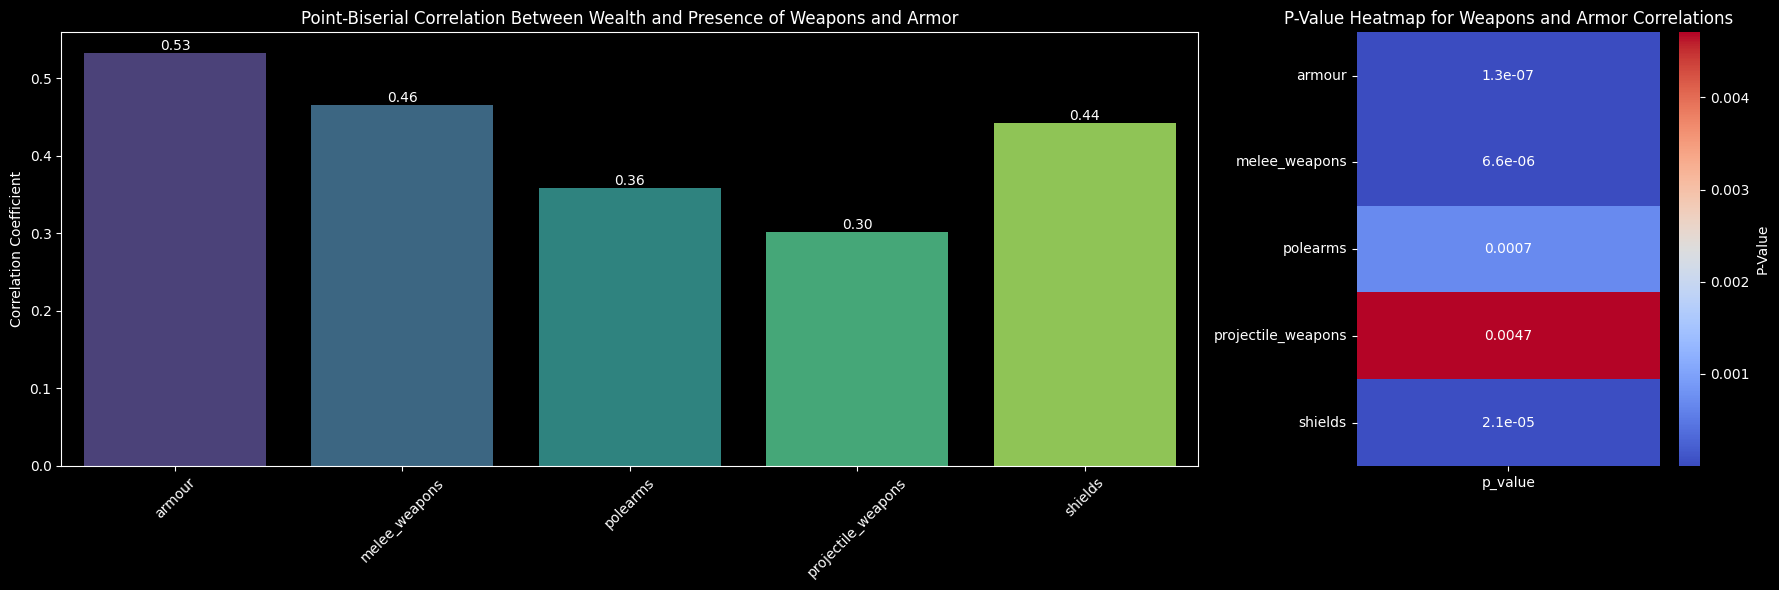

In [11]:
# Calculate point-biserial correlation coefficients and p-values for object groups
obj_groups = {
    'Dyestuffs': DYESTUFFS,
    'Exotic Objects': EXOTIC,
    'Food Preparation': FOOD_PREPARATION,
    'Household Objects': HOUSEHOLD,
    'Linens': LINENS,
    'Luxury Objects': LUXURY,
    'Weapons and Armor': WEAPONS_AND_ARMOUR,
}

for group_name, group_columns in obj_groups.items():
    correlation_results = []

    # Individual correlations using point-biserial correlation
    for col in group_columns:
        corr, p_value = pointbiserialr(df[col], df['wealth_points'])
        correlation_results.append({'column': col, 'correlation': corr, 'p_value': p_value})

    # Convert results to DataFrame
    correlation_df = pd.DataFrame(correlation_results)

    # Display results
    print(f'Point-Biserial Correlation Results for {group_name}:')
    display(correlation_df)

    # Visualize correlation results
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6), width_ratios=[3, 1])
    sns.barplot(data=correlation_df, x='column', y='correlation', palette='viridis', ci=None, ax=ax1)

    for index, row in correlation_df.iterrows():
        ax1.text(index, row['correlation'], f'{row["correlation"]:.2f}', ha='center', va='bottom')

    ax1.set_title(f'Point-Biserial Correlation Between Wealth and Presence of {group_name}')
    ax1.set_ylabel('Correlation Coefficient')
    ax1.set_xlabel(None)
    ax1.set_xticklabels(correlation_df['column'], rotation=45)
    sns.heatmap(
        correlation_df.pivot_table(index='column', values='p_value'),
        annot=True,
        cmap='coolwarm',
        cbar_kws={'label': 'P-Value'},
        ax=ax2,
    )
    ax2.set_title(f'P-Value Heatmap for {group_name} Correlations')
    ax2.set_xlabel(None)
    ax2.set_ylabel(None)
    plt.tight_layout()
    plt.show()

## Interpretation

Items like green dyestuffs, pearls, spits, sendal, and armour show the strongest associations with wealth. Categories like dyestuffs, luxury objects, and weapons and armor are generally more strongly correlated with wealth, indicating their importance as indicators of affluence.

**Dyestuffs**

Green dyestuffs have the strongest positive correlation (0.734) with wealth, and the p-value is extremely small, indicating a highly significant relationship. Ruby-red and black dyestuffs also show strong positive correlations (0.604 and 0.550, respectively) with wealth, both highly significant. Purple and Yellow dyestuffs have moderate positive correlations (0.491 and 0.483), also statistically significant. Overall, it appears that dyestuffs, particularly green and ruby-red, are strongly associated with wealth, likely reflecting their value as luxury items.

**Exotic objects**

Pearls show the strongest positive correlation (0.650) with wealth, with a highly significant p-value. Amber and objects associated with Alexandria have moderate correlations (0.477 and 0.319), both statistically significant. Objects associated with Bejaia, Damascus, and Turkey have weaker correlations, and in the case of Damascene objects the correlation is not statistically significant (p > 0.05). Pearls are the most strongly and significantly associated with wealth among exotic objects.

**Objects associated with food preparation**

Spits have the strongest positive correlation (0.634) with wealth, with a highly significant p-value. Mortars, alembics, and dough troughs show moderate correlations (0.485, 0.365, and 0.363), all statistically significant. Spits are the most strongly associated with wealth in this category, possibly reflecting their use in wealthier households.

**Household objects**

Candelabra and pillows show moderate positive correlations (0.480 and 0.411), both statistically significant. Cushions have a weaker correlation (0.234), but it is still significant. Lamps have a weak and non-significant correlation (p > 0.05).

**Linens**

Tablecloths have the strongest positive correlation (0.481) with wealth, with a highly significant p-value. Bedsheets show a moderate correlation (0.358), also significant. Tunics have a weak and non-significant correlation (p > 0.05).

**Luxury Objects**

Sendal and silk have the strongest positive correlations (0.617 and 0.596) with wealth, both highly significant. Belts and gold jewellery also show strong correlations (0.547 and 0.547), both statistically significant. Luxury objects, particularly sendal and silk, are strongly associated with wealth, reflecting their status as high-value items.

**Weapons and Armour**

Armour has the strongest positive correlation (0.532) with wealth, with a highly significant p-value. Melee Weapons, shields, and polearms show moderate correlations (0.465, 0.442, and 0.359), all statistically significant. Projectile weapons have a weaker correlation (0.302), but it is still significant.


# Do gender and/or faith have any effect on the distribution of wealth?


Two-Way ANOVA Results:
                         sum_sq    df         F    PR(>F)
C(gender)             15.787282   1.0  1.009545  0.317968
C(faith)               1.711432   1.0  0.109440  0.741626
C(gender):C(faith)    17.790375   1.0  1.137636  0.289283
Residual            1282.317460  82.0       NaN       NaN


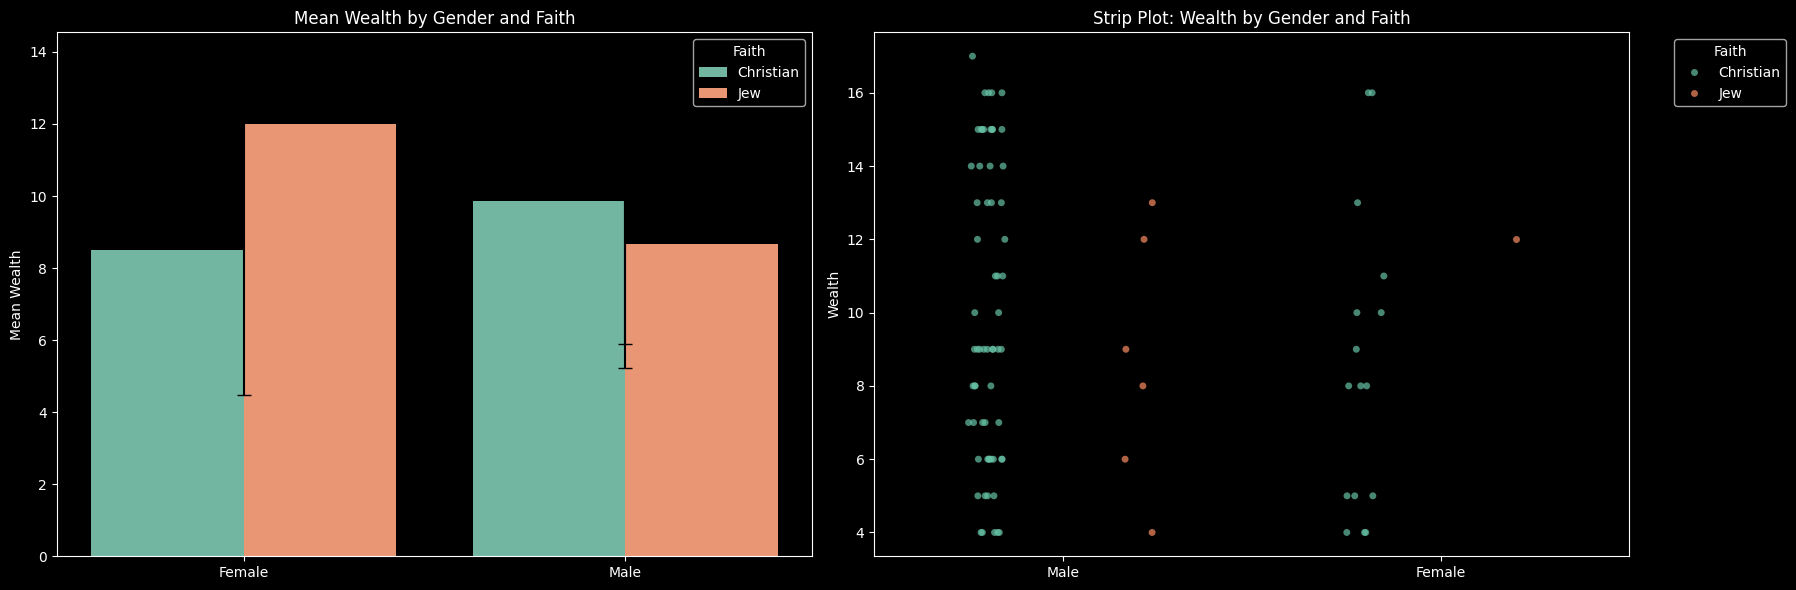

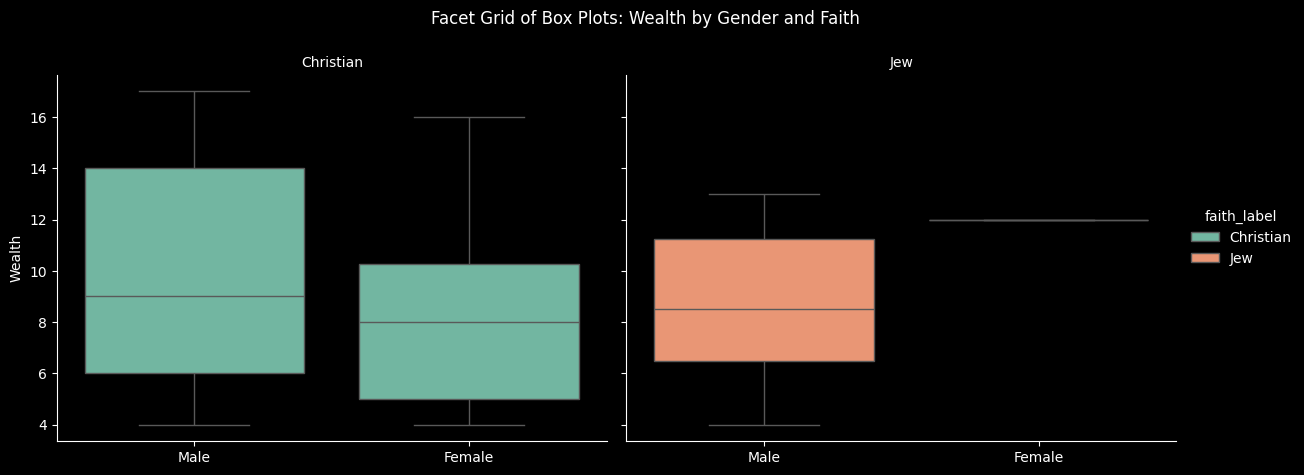

In [8]:
# Analyze the relationship between wealth (wealth_points), gender, and faith
# Two-way ANOVA
anova_model = ols('wealth_points ~ C(gender) * C(faith)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print('Two-Way ANOVA Results:')
print(anova_table)

# Group data by gender and faith to calculate mean and standard deviation of wealth_points
grouped_data = df.groupby(['gender_label', 'faith_label'])['wealth_points'].agg(['mean', 'std', 'count']).reset_index()

# Visualization:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Bar plot with error bars
sns.barplot(data=grouped_data, x='gender_label', y='mean', hue='faith_label', palette='Set2', ci=None, ax=axes[0])
for i, row in grouped_data.iterrows():
    axes[0].errorbar(
        x=i // len(grouped_data['faith_label'].unique()),
        y=row['mean'],
        yerr=row['std'],
        fmt='none',
        c='black',
        capsize=5,
    )
axes[0].set_title('Mean Wealth by Gender and Faith')
axes[0].set_xlabel('')
axes[0].set_ylabel('Mean Wealth')
# set legend using label columns
axes[0].legend(title='Faith', labels=grouped_data['faith_label'].unique())
# Strip Plot
sns.stripplot(
    data=df,
    x='gender_label',
    y='wealth_points',
    hue='faith_label',
    dodge=True,
    jitter=True,
    alpha=0.7,
    palette='Set2',
    ax=axes[1],
)
axes[1].set_title('Strip Plot: Wealth by Gender and Faith')
axes[1].set_xlabel('')
axes[1].set_ylabel('Wealth')
axes[1].legend(title='Faith', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Facet Grid of Box Plots
facet_grid = sns.catplot(
    data=df,
    x='gender_label',
    y='wealth_points',
    hue='faith_label',
    kind='box',
    col='faith_label',
    col_wrap=2,
    height=5,
    aspect=1.2,
    palette='Set2',
)
facet_grid.set_axis_labels('', 'Wealth')
facet_grid.set_titles(col_template='{col_name}')
facet_grid.set_xticklabels()
facet_grid.set_ylabels('Wealth')
facet_grid.fig.suptitle('Facet Grid of Box Plots: Wealth by Gender and Faith')
facet_grid.fig.subplots_adjust(top=0.85)


## Interpretation

The effect of gender on wealth is not statistically significant (p > 0.05), and either is the effect of faith (p > 0.05), nor that of both gender and faith combined (p > 0.05). The residual sum of squares (1282.3175) represents the unexplained variance in the model and suggests that most of the variability in wealth is not explained by gender, faith, or their interaction. Based on this date we can conclude that neither gender, faith, nor their interaction significantly affects wealth and that its variability must be attributed to other factors not included in the analysis. 

**Main Effect of Gender (`C(gender)`):**
- F-value: 1.0095
- p-value (PR(>F)): 0.3180

**Main Effect of Faith (`C(faith)`):**
- F-value: 0.1094
- p-value (PR(>F)): 0.7416

**Interaction Effect (`C(gender):C(faith)`):**
- F-value: 1.1376
- p-value (PR(>F)): 0.2893


# Can we detect changes in household wealth across time?

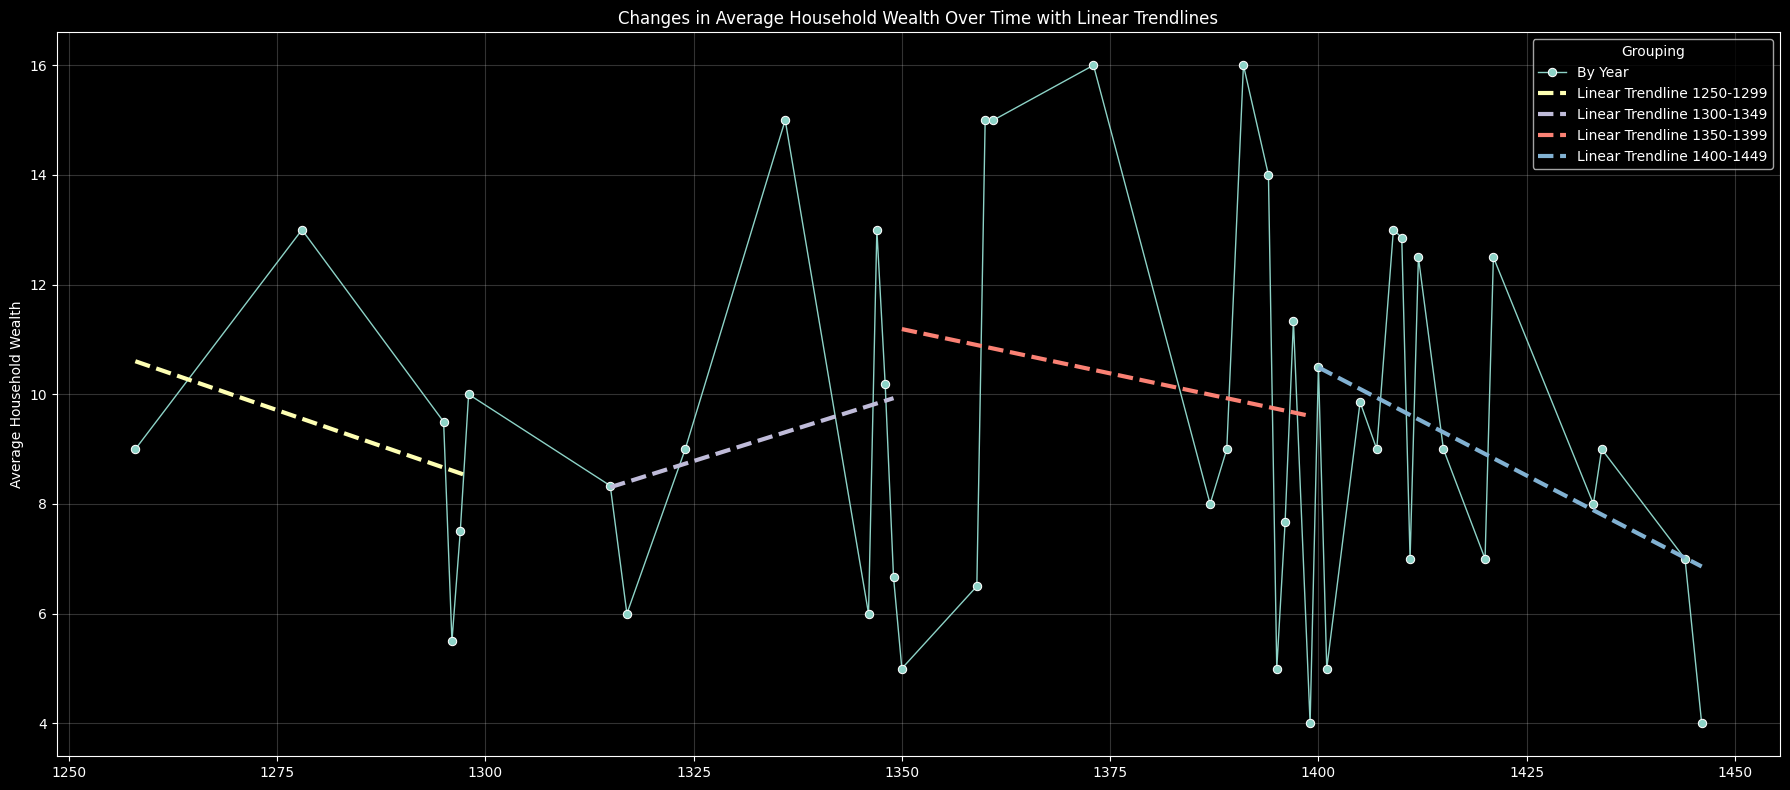

In [9]:
# Calculate average household wealth by year
average_wealth_by_year = df.groupby('year')['wealth_points'].mean().reset_index()

# Add interval trendlines to the chart
plt.figure(figsize=(18, 8))
sns.lineplot(data=average_wealth_by_year, x='year', y='wealth_points', marker='o', label='By Year', linewidth=1)


# Add linear trendlines for each interval
def add_linear_trendlines(ax, date_groupings, df):
    """Add linear trendlines for each date grouping."""
    for group, year_range in date_groupings.items():
        interval_data = df[df['year'].isin(year_range)].groupby('year')['wealth_points'].mean().reset_index()
        if not interval_data.empty:
            # Fit a linear trendline
            p = Polynomial.fit(interval_data['year'], interval_data['wealth_points'], 1)
            trendline = p(interval_data['year'])
            ax.plot(interval_data['year'], trendline, linestyle='--', linewidth=3, label=f'Linear Trendline {group}')


ax = plt.gca()
add_linear_trendlines(ax, DATE_GROUPINGS, df)

plt.title('Changes in Average Household Wealth Over Time with Linear Trendlines')
plt.xlabel(None)
plt.ylabel('Average Household Wealth')
plt.legend(title='Grouping')
plt.grid(True, alpha=0.2)  # noqa: FBT003
plt.tight_layout()
plt.show()


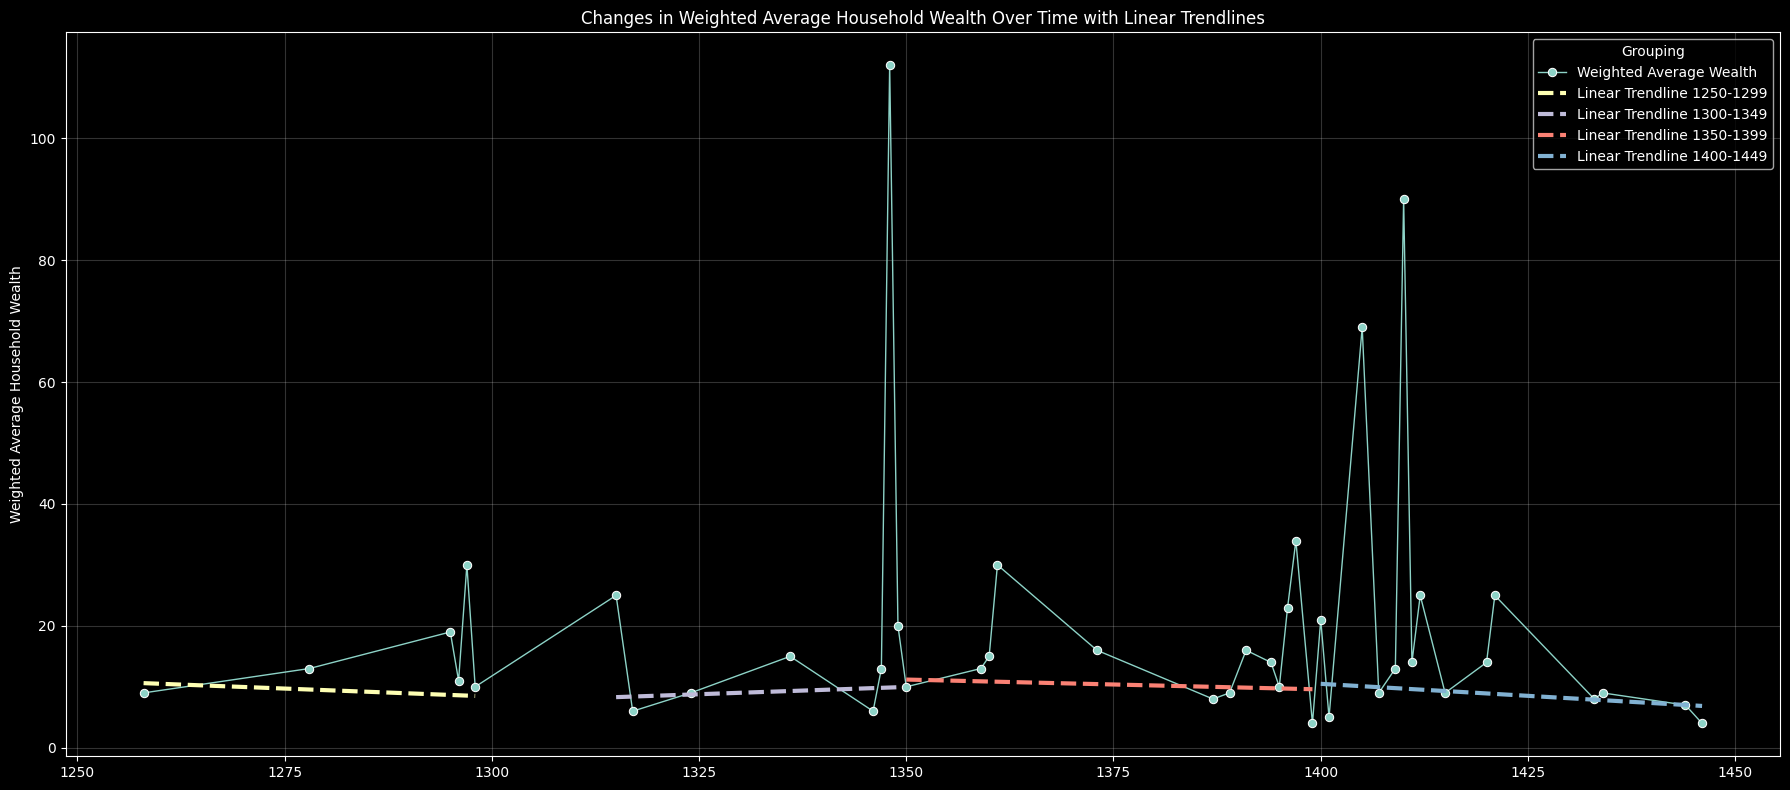

In [10]:
# Calculate weighted average household wealth by year
weighted_wealth_by_year = (
    df.groupby('year').apply(lambda x: (x['wealth_points'] * x['id'].count()).sum() / x['id'].count()).reset_index()
)
weighted_wealth_by_year.columns = ['year', 'weighted_average_wealth']

# Plot weighted average household wealth by year
plt.figure(figsize=(18, 8))
sns.lineplot(
    data=weighted_wealth_by_year,
    x='year',
    y='weighted_average_wealth',
    marker='o',
    label='Weighted Average Wealth',
    linewidth=1,
)


# Add linear trendlines for each interval
def add_linear_trendlines(ax, date_groupings, df):
    """Add linear trendlines for each date grouping."""
    for group, year_range in date_groupings.items():
        interval_data = df[df['year'].isin(year_range)].groupby('year')['wealth_points'].mean().reset_index()
        if not interval_data.empty:
            # Fit a linear trendline
            p = Polynomial.fit(interval_data['year'], interval_data['wealth_points'], 1)
            trendline = p(interval_data['year'])
            ax.plot(interval_data['year'], trendline, linestyle='--', linewidth=3, label=f'Linear Trendline {group}')


ax = plt.gca()
add_linear_trendlines(ax, DATE_GROUPINGS, df)

plt.title('Changes in Weighted Average Household Wealth Over Time with Linear Trendlines')
plt.xlabel(None)
plt.ylabel('Weighted Average Household Wealth')
plt.legend(title='Grouping')
plt.grid(True, alpha=0.2)  # noqa: FBT003
plt.tight_layout()
plt.show()
